# Deep Learning 
## Project 1 : Image Classification and Regression

In [1]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Input, Conv2DTranspose, UpSampling2D, Concatenate, Reshape, BatchNormalization, Dropout
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import metrics

Using TensorFlow backend.


###  Functions for geometric shape generation : 
We use the functions from the file mp1.py

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


We test the functions and generate a few shapes :

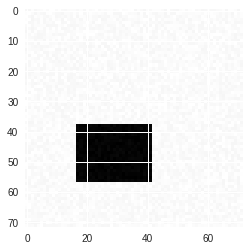

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

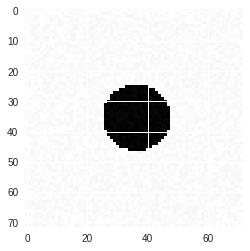

In [4]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

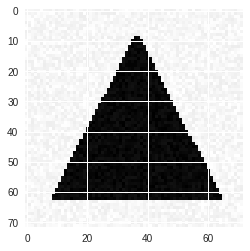

In [5]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## 3. Simple classification 
Generating the classification dataset :

In [0]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

We start by generating a training dataset of size 300 and a test set of size 100.

In [7]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We convert the labels using one hot encoding ie. a rectangle will have the label $[1,0,0]$, a disk the label $[0,1,0]$ and a triangle the label $[0,0,1]$

In [0]:
Y_train_categorical = np_utils.to_categorical(Y_train, 3) 

We build a simple linear classifier with one dense layer composed of 3 units; one for each label. We use the softmax activation to output the probability of each label.

In [0]:
model = Sequential()
model.add(Dense(3, input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
model.add(Activation('softmax'))

We start by optimizing using Stochastic Gradient Descent with a momentum of 0.9 and a learning rate decay factor of $10^{-4}$. We train the network over 10 epochs with batch size 64 but we notice that it reaches a 100% accuracy from the first epoch. We use 20% of the dataset for validation. The loss to be optimized is the categorical cross-entropy which is suited for classification tasks where the model outputs a probability value for each class.

In [10]:
sgd = SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[metrics.categorical_accuracy])
model.fit(X_train, Y_train_categorical, epochs=10, batch_size=64, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 1s 4ms/step - loss: 8.7501 - categorical_accuracy: 0.2958 - val_loss: 10.2081 - val_categorical_accuracy: 0.3667
Epoch 2/10
240/240 [==============================] - 0s 115us/step - loss: 11.0140 - categorical_accuracy: 0.3167 - val_loss: 10.2081 - val_categorical_accuracy: 0.3667
Epoch 3/10
240/240 [==============================] - 0s 115us/step - loss: 11.0140 - categorical_accuracy: 0.3167 - val_loss: 10.2081 - val_categorical_accuracy: 0.3667
Epoch 4/10
240/240 [==============================] - 0s 121us/step - loss: 11.0140 - categorical_accuracy: 0.3167 - val_loss: 10.2081 - val_categorical_accuracy: 0.3667
Epoch 5/10
240/240 [==============================] - 0s 111us/step - loss: 11.0140 - categorical_accuracy: 0.3167 - val_loss: 10.2081 - val_categorical_accuracy: 0.3667
Epoch 6/10
240/240 [==============================] - 0s 120us/step - loss: 11.0140 - categorical_accuracy: 

Now we use the Adam optimizer with the default parameters, and a batch size of 32

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy])
model.fit(X_train, Y_train_categorical, epochs=10, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 0s 743us/step - loss: 11.0140 - categorical_accuracy: 0.3167 - val_loss: 10.2081 - val_categorical_accuracy: 0.3667
Epoch 2/10
240/240 [==============================] - 0s 180us/step - loss: 11.0140 - categorical_accuracy: 0.3167 - val_loss: 10.2081 - val_categorical_accuracy: 0.3667
Epoch 3/10
240/240 [==============================] - 0s 183us/step - loss: 11.0140 - categorical_accuracy: 0.3167 - val_loss: 10.2081 - val_categorical_accuracy: 0.3667
Epoch 4/10
240/240 [==============================] - 0s 190us/step - loss: 11.0140 - categorical_accuracy: 0.3167 - val_loss: 10.2081 - val_categorical_accuracy: 0.3667
Epoch 5/10
240/240 [==============================] - 0s 188us/step - loss: 11.0140 - categorical_accuracy: 0.3167 - val_loss: 10.2081 - val_categorical_accuracy: 0.3667
Epoch 6/10
240/240 [==============================] - 0s 198us/step - loss: 11.0140 - categorical_accurac

We test the model by generating a disk and predicting its label :

In [12]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

### 4. Visualization of the solution

We visualize the weights of the linear classifier and notice the 3 shapes present in our dataset:

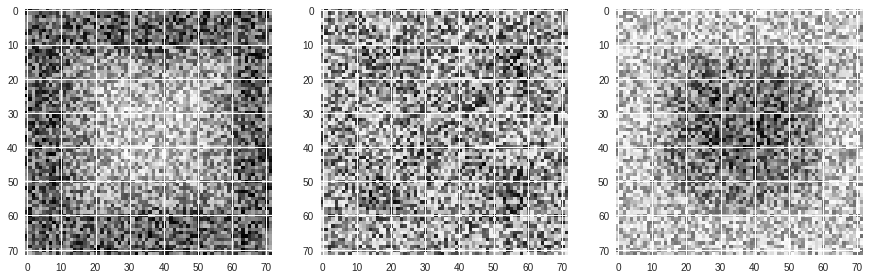

In [13]:
weights = model.get_weights()
classifier_matrix = weights[0]
fig, ax = plt.subplots(1,3, figsize=(15,15))
for i in range(3):
    ax[i].imshow(classifier_matrix[:,i].reshape(IMAGE_SIZE,IMAGE_SIZE))

### 5. A more Difficult Classification Problem

We create a new dataset where the shapes are allowed to move by setting free_location to True. Once again, we perform a one hot encoding to convert labels into binary vectors.

In [14]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train_categorical = np_utils.to_categorical(Y_train, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We re-train our previous model on this new dataset :

In [15]:
model = Sequential()
model.add(Dense(3, input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
model.add(Activation('softmax'))
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[metrics.categorical_accuracy])
model.fit(X_train, Y_train_categorical, epochs=100, batch_size=64, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/100
240/240 [==============================] - 0s 771us/step - loss: 1.9858 - categorical_accuracy: 0.3250 - val_loss: 2.1325 - val_categorical_accuracy: 0.2667
Epoch 2/100
240/240 [==============================] - 0s 125us/step - loss: 1.6050 - categorical_accuracy: 0.3500 - val_loss: 1.5931 - val_categorical_accuracy: 0.4833
Epoch 3/100
240/240 [==============================] - 0s 119us/step - loss: 1.2852 - categorical_accuracy: 0.5083 - val_loss: 1.4403 - val_categorical_accuracy: 0.3167
Epoch 4/100
240/240 [==============================] - 0s 163us/step - loss: 1.2395 - categorical_accuracy: 0.4292 - val_loss: 1.1519 - val_categorical_accuracy: 0.5667
Epoch 5/100
240/240 [==============================] - 0s 121us/step - loss: 1.0892 - categorical_accuracy: 0.5042 - val_loss: 1.1086 - val_categorical_accuracy: 0.4333
Epoch 6/100
240/240 [==============================] - 0s 135us/step - loss: 1.0647 - categorical_accuracy: 0.

The model doesn't perform very well and reaches a higher accuracy on the training set compared to the validation set which means it is overfitting.
We now generate a test set and evaluate the model on the new data.

In [16]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]
  
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [17]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 116us/step


[0.9752214996019999, 0.6]

As expected, the model has a low accuracy and only able to correctly predict 57% of the labels. It is still better than random prediction (1/3), but the data is no longer linearly separable when shapes are allowed to move which leads to the low accuracy.

### Using convolutional layers :
We generate a bigger dataset of 1000 training samples to implement a new architecture, one which has convolutional layers this time. We use 3 convolutional layers with 16 5*5 filters, followed by a dense layer.

In [18]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
Y_train_categorical = np_utils.to_categorical(Y_train, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [19]:
model = Sequential()
model.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train.reshape(1000,IMAGE_SIZE,IMAGE_SIZE,1), Y_train_categorical, batch_size=32, epochs=30, validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 1s 2ms/step - loss: 1.0877 - acc: 0.4062 - val_loss: 1.0666 - val_acc: 0.3950
Epoch 2/30
800/800 [==============================] - 0s 473us/step - loss: 1.0314 - acc: 0.4875 - val_loss: 1.0086 - val_acc: 0.5500
Epoch 3/30
800/800 [==============================] - 0s 459us/step - loss: 0.9233 - acc: 0.5913 - val_loss: 0.9505 - val_acc: 0.5700
Epoch 4/30
800/800 [==============================] - 0s 458us/step - loss: 0.8186 - acc: 0.6525 - val_loss: 0.7409 - val_acc: 0.7150
Epoch 5/30
800/800 [==============================] - 0s 479us/step - loss: 0.6865 - acc: 0.7025 - val_loss: 0.6577 - val_acc: 0.7500
Epoch 6/30
800/800 [==============================] - 0s 454us/step - loss: 0.5767 - acc: 0.7838 - val_loss: 0.5223 - val_acc: 0.8100
Epoch 7/30
800/800 [==============================] - 0s 458us/step - loss: 0.4748 - acc: 0.8275 - val_loss: 0.4282 - val_acc: 0.8650
Epoch 8/30
800/800

The model performs much better than the simple linear classifier, this is because the convolutional layers are able to extract the right features for the different shapes independantly of their locations which yields a better prediction when applying the fully connected layer at the end. We get a test accuracy of 95%.

In [20]:
loss, accuracy = model.evaluate(X_test.reshape(300, IMAGE_SIZE, IMAGE_SIZE, 1), Y_test)
print("Loss :", loss, ", Accuracy :", accuracy)

300/300 [==============================] - 0s 233us/step
Loss : 0.16438515305519105 , Accuracy : 0.9500000007947286



### 6. A regression problem
Now we are interested in predicting the image locations of the vertices of a triangle given an image of this triangle. In order not to predict the vertices arbitrarly, we sort them in a clockwise manner to facilitate prediction.

In [0]:
import itertools 

def angle_with_start(coord, start):
    vec = coord - start
    return np.angle(np.complex(vec[0], vec[1]))


def sort_clockwise(points):
    
    coords = [np.array([points[2*i], points[2*i+1]]) for i in range(len(points) // 2)]

    
    coords = sorted(coords, key=lambda coord: np.linalg.norm(coord))
    start = coords[0]
    rest = coords[1:]

    # sort the remaining coordinates by angle
    # with reverse=True because we want to sort by clockwise angle
    rest = sorted(rest, key=lambda coord: angle_with_start(coord, start), reverse=True)

    # our first coordinate should be our starting point
    rest.insert(0, start)
    
    return np.array(list(itertools.chain(*rest)))

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
        
        Y[i] = sort_clockwise(Y[i])
        
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]
  
import matplotlib.patches as patches

def visualize_prediction(x, y, ax):
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    return ax

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

We generate a dataset set comprising of 1000 samples.

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


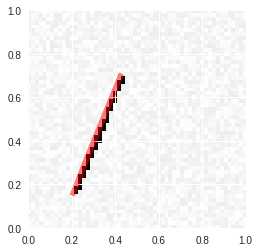

In [22]:
[X_train, Y_train] = generate_dataset_regression(1000,20)
fig, ax = plt.subplots()
ax = visualize_prediction(X_train[0], Y_train[0], ax)
plt.show()

We implement the following architecture : 

*   5 convolutional layers
*   3 dense layers

We use the mean squared loss and Adam as an optimizer.


In [23]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='relu'))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(1000,IMAGE_SIZE,IMAGE_SIZE,1), Y_train, batch_size=32, epochs=100, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 32)        9248      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 32)        9248      
__________

In [24]:
[X_test, Y_test] = generate_dataset_regression(100,20)

Creating data:
0
10
20
30
40
50
60
70
80
90


In [25]:
loss = model.evaluate(X_test.reshape(100, IMAGE_SIZE, IMAGE_SIZE, 1), Y_test)
print('Loss :', loss)

100/100 [==============================] - 0s 436us/step
Loss : 0.01309077648445964


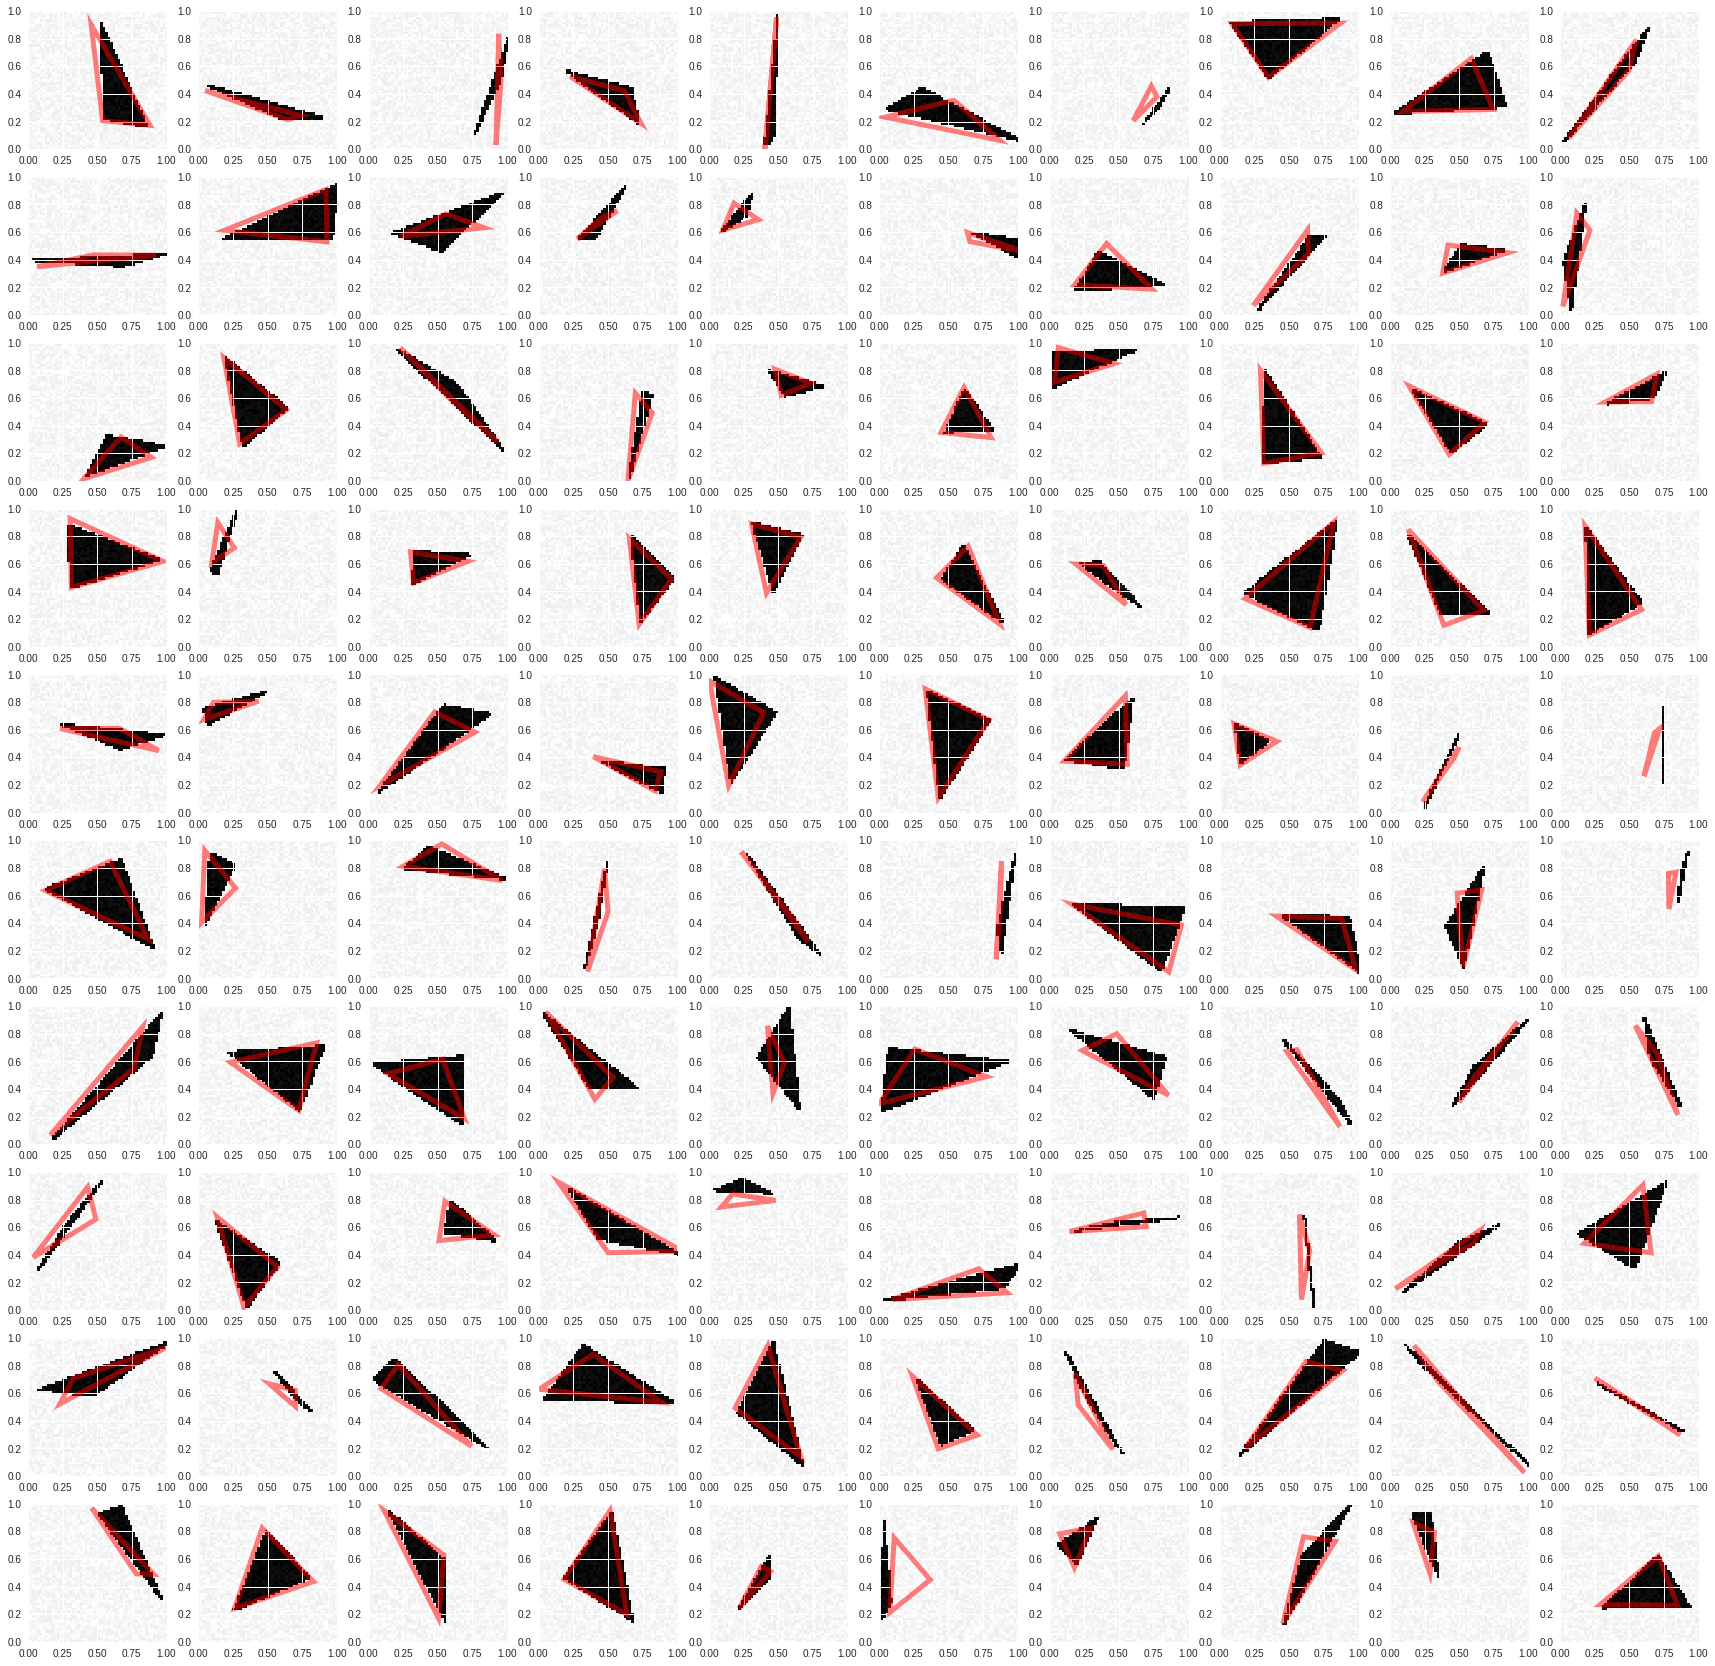

In [26]:
Y_predict = model.predict(X_test.reshape(100, IMAGE_SIZE, IMAGE_SIZE, 1))
n_col = 10
n_row = 10
x=0
fig, ax = plt.subplots(n_row, n_col, figsize=(30,30))
for i in range(n_row):
    for j in range(n_col):
        visualize_prediction(X_test[x], Y_predict[x], ax[i][j])
        x += 1
plt.show()

## 7. Denoising

We create new functions to generate images and their noisy versions.

In [0]:
def generate_a_rectangle2(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    noisy_im = generate_a_drawing(figsize, U, V, noise)
    clean_im = generate_a_drawing(figsize, U, V, 0)
    return (noisy_im, clean_im)


def generate_a_disk2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    noisy_im = generate_a_drawing(figsize, U, V, noise)
    clean_im = generate_a_drawing(figsize, U, V, 0)
    return (noisy_im, clean_im)

def generate_a_triangle2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    noisy_im = generate_a_drawing(figsize, U, V, noise)
    clean_im = generate_a_drawing(figsize, U, V, 0)
    return (noisy_im, clean_im)

In [0]:
def generate_dataset_denoising(nb_samples, free_location=False, noise_amplitude=20):
    # Getting im_size:
    im_size = generate_a_rectangle2()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        noise = np.random.rand()*noise_amplitude
        if category == 0:
            X[i], Y[i] = generate_a_rectangle2(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk2(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle2(noise, free_location)
        
    return [X, Y]

We generate a dataset of 1000 samples.

In [29]:
[X, Y] = generate_dataset_denoising(1000, True, noise_amplitude=100)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


We implement a version of the U-Net architecture with 3 stages.


In [30]:
input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE,1))

conv1a = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
conv1b = Conv2D(64, (3,3), activation='relu', padding='same')(conv1a)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1b)


conv2a = Conv2D(128, (3,3), activation='relu', padding='same')(pool1)
conv2b = Conv2D(128, (3,3), activation='relu', padding='same')(conv2a)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2b)


conv3a = Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
conv3b = Conv2D(128, (3,3), activation='relu', padding='same')(conv3a)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3b)


up4 = UpSampling2D(size=(2,2))(pool3)
up_conv4 = Conv2D(128, (2,2), activation='relu', padding='same')(up4)
merge4 = Concatenate(axis=3)([conv3b,up_conv4])
conv4b = Conv2D(128, (2,2), activation='relu', padding='same')(merge4)
conv4c = Conv2D(128, (2,2), activation='relu', padding='same')(conv4b)

up5 = UpSampling2D(size=(2,2))(conv4c)
up_conv5 = Conv2D(128, (2,2), activation='relu', padding='same')(up5)
merge5 = Concatenate(axis=3)([conv2b,up_conv5])
conv5b = Conv2D(128, (2,2), activation='relu', padding='same')(merge5)
conv5c = Conv2D(128, (2,2), activation='relu', padding='same')(conv5b)


up6 = UpSampling2D(size=(2,2))(conv5c)
up_conv6 = Conv2D(64, (2,2), activation='relu', padding='same')(up6)
merge6 = Concatenate(axis=3)([conv1b,up_conv6])
conv6b = Conv2D(64, (2,2), activation='relu', padding='same')(merge6)
conv6c = Conv2D(64, (2,2), activation='relu', padding='same')(conv6b)


decoded = Conv2D(1, (3,3), activation='relu', padding='same')(conv6c)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.fit(X.reshape(1000,IMAGE_SIZE,IMAGE_SIZE,1), Y.reshape(1000,IMAGE_SIZE,IMAGE_SIZE,1), batch_size=64, epochs=50, validation_split=0.2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 72, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 72, 72, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 72, 72, 64)   36928       conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 36, 36, 64)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 

Creating data:
0


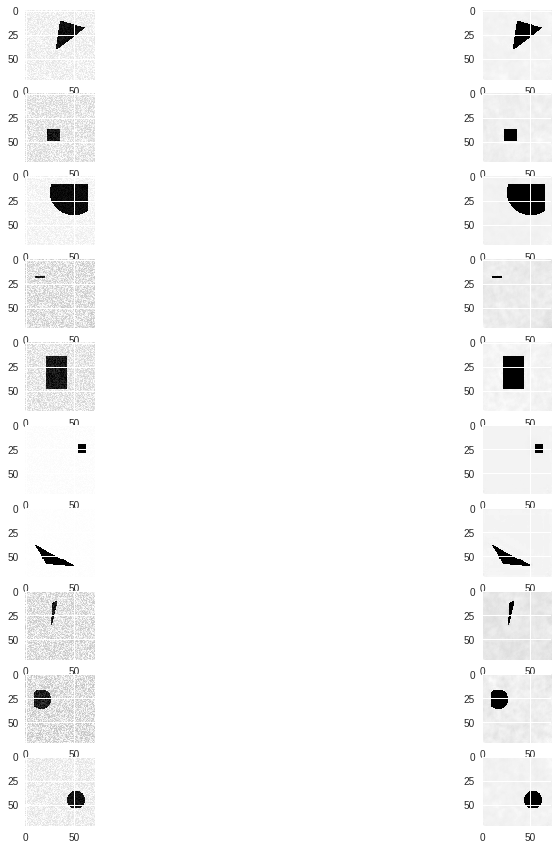

In [37]:
[X_test, Y_test] = generate_dataset_denoising(10, True, noise_amplitude=100)
Y_test_predict = autoencoder.predict(X_test.reshape(10,IMAGE_SIZE, IMAGE_SIZE, 1))
fig, ax = plt.subplots(10,2, figsize=(20,20))
for i in range(10):
    ax[i][0].imshow(X_test[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    ax[i][1].imshow(Y_test_predict[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')